In [ ]:
# Install the necessary libraries
!pip3 install emoji
!pip3 install contractions
!pip3 install keras_tuner
!pip3 install transformers

     |████████████████████████████████| 174 kB 4.2 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=f05d5b199befe53166b76428d0a2aaccbda517cef0a6b68391c0fc3bb7e9747e
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji
     |████████████████████████████████| 321 kB 4.1 MB/s 
     |████████████████████████████████| 284 kB 45.2 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85448 sha256=07b7d787b75dd3ac8391d732ed38abdb35cbf1d3aa3e2569546160ac2934f564
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
     |████████████████████████████████| 98 kB 3.3 MB/s 
     |████████████████████████████████| 3.4 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 42.6 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     

In [ ]:
# Import the necessary libraries
import re
import os
import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm
tqdm.pandas()

import emoji
import string
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import pickle

from keras.preprocessing.sequence import pad_sequences

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, GRU, Bidirectional, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch, Objective
from keras.utils.vis_utils import plot_model

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback, TrainingArguments, Trainer
import shutil

from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Set the notebook hyperparameter
TRAIN = False

# Data Extraction

In [ ]:
# Download and unzip the dataset
!gdown --id PRIVATEID
!unzip -q -o dataset.zip -d /content/dataset

In [ ]:
# Utilised functions
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [ ]:
# Load the dataset into a dataframe
path = '/content/dataset/en'
filenames = sorted_alphanumeric(os.listdir(path))

df = pd.DataFrame(columns=['Text', 'Author', 'Truth'])

for index, filename in enumerate(tqdm(filenames)):
    if filename[-3:] == 'xml':
        root = ET.parse(path + '/' + filename).getroot()

        truth = int(root.get('class'))
        texts = root.findall('documents/document')

        for text in texts:
            df.loc[len(df)] = [text.text, index, truth]

In [ ]:
# Preview the dataset
print(f"Number of offensive tweets: {df[df['Truth'] == 1].shape[0]}")
print(f"Number of non-offensive tweets: {df[df['Truth'] == 0].shape[0]}")
df.head()

# Data Cleaning

In [ ]:
# Download and read the extracted dataset (use to skip data extraction)
# !gdown --id PRIVATEID
# df = pd.read_pickle('/content/dataset.pkl')

In [ ]:
# Utilised functions
# Normalize sequences of at least 3 repeated characters with a maximum of two letters
def replace_more_than_three(s):
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL) 
    return pattern.sub(r"\1\1", s)
    
def clean_text(sentence):
    
    # Remove the dataset specific terms and other html leftovers
    elements = {r'#URL#': '', r'#USER#': '', r'#HASHTAG#': '', r'&amp': ' ', r'&quot': '', r'&apos': '', 
                r'&lt': '', r'&gt': '', r',(?!\s)': ', ', r'\\\'(?=[a-zA-Z])': r'\''}
    for key, value in elements.items():
        sentence = re.sub(key, value, sentence)

    # Expand contractions (ex: you're -> you are)
    sentence = contractions.fix(sentence, slang=True)

    # Normalize sequences of at least 3 repeated characters with a maximum of two letters (ex: hiiiiii -> hii)
    sentence = replace_more_than_three(sentence)

    # Remove numbers
    sentence = re.sub(r'\d+', '', sentence)

    # Remove punctuations
    sentence = sentence.translate(str.maketrans(' ', ' ', string.punctuation))

    # Transform emojis into their aliases
    sentence = emoji.demojize(sentence)
    sentence = re.sub(r':', ' ', sentence)

    # Remove extra white spaces
    sentence = ' '.join(sentence.split())

    # Remove any left or right spacing
    sentence.strip()

    return sentence

In [ ]:
# Clean the raw texts
df['Clean'] = df['Text'].progress_apply(lambda txt: clean_text(txt))

# Rearrange the columns
df = df[['Text', 'Clean', 'Author', 'Truth']]

100%|██████████| 40000/40000 [00:03<00:00, 10110.46it/s]


In [ ]:
# Preview the dataset
df.head()

,Text,Clean,Author,Truth
0,"""Hey Jamal (snickering uncontrollable) You wan...",Hey Jamal snickering uncontrollable You want s...,0,1
1,RT #USER#: Cotton coming out with a banger #URL#,RT Cotton coming out with a banger,0,1
2,This is meant to be sarcasm but it's a good po...,This is meant to be sarcasm but it is a good p...,0,1
3,Nick really just compared homosexuality to peo...,Nick really just compared homosexuality to peo...,0,1
4,PROTECT AMERICA FIRST! LET'S GO!!!!!!!! #URL#,PROTECT AMERICA FIRST LET US GO,0,1


In [ ]:
# Divide the dataset into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Clean'], df['Truth'], test_size=0.2, shuffle=True, random_state=8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, shuffle=True, random_state=8) # 0.125 x 0.8 = 0.1

print(f'Number of tweets in training set: {X_train.shape[0]}')
print(f'Number of tweets in validation set: {X_val.shape[0]}')
print(f'Number of tweets in test set: {X_test.shape[0]}')

Number of tweets in training set: 28000
Number of tweets in validation set: 4000
Number of tweets in test set: 8000


# Modelling

In [ ]:
# Utilised functions
def majority_voting(model, transformer=False):
    autors = [df['Author'][i] for i in test_labels.keys()]
    majority_voting = pd.DataFrame(columns = ['Author', 'True', 'Pred'])
    majority_voting['Author'] = pd.unique(autors)

    predictions =  pd.DataFrame(columns = ['ID', 'Author', 'Label'])
    if transformer:
        transformer_pred = model.predict(test_dataset)
        predictions['Label'] = [np.argmax(s) for s in transformer_pred[0]]
    else:
        predictions['Label'] = np.round(model.predict(test_features)).reshape(8000).tolist()
    predictions['ID'] = test_labels.keys()
    predictions['Author'] = autors

    for author in majority_voting['Author']:
      
        # Get the true labels
        majority_voting.loc[majority_voting['Author'] == author, 'True'] = df['Truth'][[i for i in (predictions['ID'][predictions['Author'] == author])][0]]

        # Get all the predicted label given an author
        labels = predictions[predictions['Author'] == author]

        # Implement majority vote
        if(len(labels[labels['Label'] == 1]) > len(labels[labels['Label'] == 0])):  
            majority_voting.loc[majority_voting['Author'] == author, 'Pred'] = 1
        else:
            majority_voting.loc[majority_voting['Author'] == author, 'Pred'] = 0
    
    return [i for i in majority_voting['True']], [i for i in majority_voting['Pred']]

def plot_cm(labels, pred):
    cm = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

## Model (SVM)

In [ ]:
# Fit the TF-IDF vectorizer and transform the texts
vectorizer = TfidfVectorizer().fit(X_train)
train_features = vectorizer.transform(X_train)
test_features = vectorizer.transform(X_test)

# Change data type of labels to int64
train_labels = y_train.astype('int64')
test_labels = y_test.astype('int64')

In [ ]:
# Define the model and distribution for random search
if TRAIN:
    model = SVC()
    distributions = {'C': uniform(loc=0, scale=1), 'kernel': ['poly', 'rbf', 'sigmoid']}

In [ ]:
# Get the best model hyperparameters using random search
if TRAIN:
    clf = RandomizedSearchCV(model, distributions, 
                            scoring='accuracy', 
                            cv=5, n_iter=3, verbose=2)

    best_svm_model = clf.fit(train_features, train_labels)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...................C=0.0658448740535259, kernel=rbf; total time= 1.2min
[CV] END ...................C=0.0658448740535259, kernel=rbf; total time= 1.2min
[CV] END ...................C=0.0658448740535259, kernel=rbf; total time= 1.2min
[CV] END ...................C=0.0658448740535259, kernel=rbf; total time= 1.2min
[CV] END ...................C=0.0658448740535259, kernel=rbf; total time= 1.2min
[CV] END ...............C=0.2641533788656698, kernel=sigmoid; total time= 1.1min
[CV] END ...............C=0.2641533788656698, kernel=sigmoid; total time= 1.1min
[CV] END ...............C=0.2641533788656698, kernel=sigmoid; total time= 1.1min
[CV] END ...............C=0.2641533788656698, kernel=sigmoid; total time= 1.1min
[CV] END ...............C=0.2641533788656698, kernel=sigmoid; total time= 1.1min
[CV] END ...................C=0.5935775687368425, kernel=rbf; total time= 1.4min
[CV] END ...................C=0.5935775687368425,

In [ ]:
 # Print the best model results and hyperparameters
 if TRAIN:
    print(f'Best Accuracy Score: {round(best_svm_model.best_score_, 3)}')
    print(f'Best Hyperparameters: {best_svm_model.best_params_}')

Best Accuracy Score: 0.612
Best Hyperparameters: {'C': 0.5935775687368425, 'kernel': 'rbf'}


In [ ]:
# Save the best model
if TRAIN:
    with open('best_svm_model.pkl', 'wb') as f:
        pickle.dump(best_svm_model, f)

In [ ]:
# Download and load the best SVM model
if TRAIN == False:
    !gdown --id 1YSOyxHLkgFP8_g4RCJSTo2-6m_LlRTaZ
    with open('best_svm_model.pkl', 'rb') as f:
        best_svm_model = pickle.load(f)

Downloading...
From: https://drive.google.com/uc?id=1YSOyxHLkgFP8_g4RCJSTo2-6m_LlRTaZ
To: /content/best_svm_model.pkl
100% 4.18M/4.18M [00:00<00:00, 36.8MB/s]


              precision    recall  f1-score   support

           0       0.74      0.79      0.76       100
           1       0.77      0.72      0.75       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.75       200
weighted avg       0.76      0.76      0.75       200



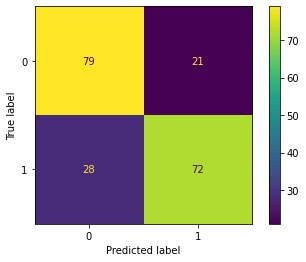

In [ ]:
# Evaluate the best SVM model on the test set
true, pred = majority_voting(best_svm_model)
print(classification_report(true, pred))
plot_cm(true, pred)

## Model (LSTM & GRU)

In [ ]:
# Download the GloVe embeddings file
!gdown https://nlp.stanford.edu/data/glove.6B.zip

# Unzip the GloVe embeddings file
!unzip -q -o glove.6B.zip -d embeddings

Downloading...
From: https://nlp.stanford.edu/data/glove.6B.zip
To: /content/glove.6B.zip
100% 862M/862M [02:40<00:00, 5.38MB/s]


In [ ]:
# Utilised functions
def encode(sentence, embeddings):
    oov_dict = {}
    features = []

    tokens = word_tokenize(sentence)
    for word in tokens:

        # If the word is not in the GloVe dictionary (OOV), return random array
        if word not in embeddings:
            if word not in oov_dict:
              
                # Generate random array of size 300 and store in dict
                oov_dict[word] = np.random.rand(300)
            
            features.append(oov_dict[word])

        else:
          features.append(embeddings[word])
    
    return features

def plot_history(hist):
    plt.figure(figsize=(20, 7))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss against Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['Accuracy'])
    plt.plot(hist.history['val_Accuracy'])
    plt.title('Accuracy against Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Create the dictionary of GloVe embeddings
glove_dict = {}
with open('/content/embeddings/glove.6B.300d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], 'float32')
        glove_dict[word]=vector

In [ ]:
# Encode the sentences using GloVe embeddings
train_features = X_train.apply(encode, embeddings=glove_dict)
val_features = X_val.apply(encode, embeddings=glove_dict)
test_features = X_test.apply(encode, embeddings=glove_dict)

# Pad the features to a fixed length
max_length = 50
train_features = np.array(pad_sequences(train_features, maxlen=max_length, padding='post', dtype='float32'))
val_features = np.array(pad_sequences(val_features, maxlen=max_length, padding='post', dtype='float32'))
test_features = np.array(pad_sequences(test_features, maxlen=max_length, padding='post', dtype='float32'))

# Change data type of labels to float32
train_labels = y_train.astype('float32')
val_labels = y_val.astype('float32')
test_labels = y_test.astype('float32')

### Bidirectional LSTM

In [ ]:
# Bidirectional LSTM with a Dense layer
if TRAIN:
    def lstm_model(hp):
        model = Sequential()
        model.add(InputLayer(input_shape=(50, 300)))
        model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=320, step=64, default=256))))
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-5), metrics='Accuracy')
        return model

    # Hyperparameter optimization using random search
    tuner = RandomSearch(lstm_model, objective=Objective('val_Accuracy', direction='max'), max_trials=3, overwrite=True)
    tuner.search(train_features, train_labels, epochs=5, validation_data=(val_features, val_labels), batch_size=32)

Trial 3 Complete [00h 00m 55s]
val_Accuracy: 0.5517500042915344

Best val_Accuracy So Far: 0.5522500276565552
Total elapsed time: 00h 03m 48s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Train the best model for 10 epochs
if TRAIN:
    best_lstm_model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
    hist_lstm = best_lstm_model.fit(train_features, train_labels, epochs=10, validation_data=(val_features, val_labels), batch_size=32, 
                                    callbacks=EarlyStopping(monitor='val_loss', patience=3))

    # Save the best model
    best_lstm_model.save('best_lstm_model.h5')

Epoch 1/10
875/875 [==============================] - 13s 12ms/step - loss: 0.6920 - Accuracy: 0.5197 - val_loss: 0.6916 - val_Accuracy: 0.5260
Epoch 2/10
875/875 [==============================] - 9s 11ms/step - loss: 0.6890 - Accuracy: 0.5391 - val_loss: 0.6892 - val_Accuracy: 0.5387
Epoch 3/10
875/875 [==============================] - 11s 12ms/step - loss: 0.6854 - Accuracy: 0.5505 - val_loss: 0.6856 - val_Accuracy: 0.5475
Epoch 4/10
875/875 [==============================] - 9s 10ms/step - loss: 0.6809 - Accuracy: 0.5615 - val_loss: 0.6835 - val_Accuracy: 0.5487
Epoch 5/10
875/875 [==============================] - 9s 10ms/step - loss: 0.6779 - Accuracy: 0.5658 - val_loss: 0.6841 - val_Accuracy: 0.5452
Epoch 6/10
875/875 [==============================] - 9s 11ms/step - loss: 0.6756 - Accuracy: 0.5715 - val_loss: 0.6849 - val_Accuracy: 0.5510
Epoch 7/10
875/875 [==============================] - 9s 10ms/step - loss: 0.6738 - Accuracy: 0.5741 - val_loss: 0.6827 - val_Accuracy: 0.54

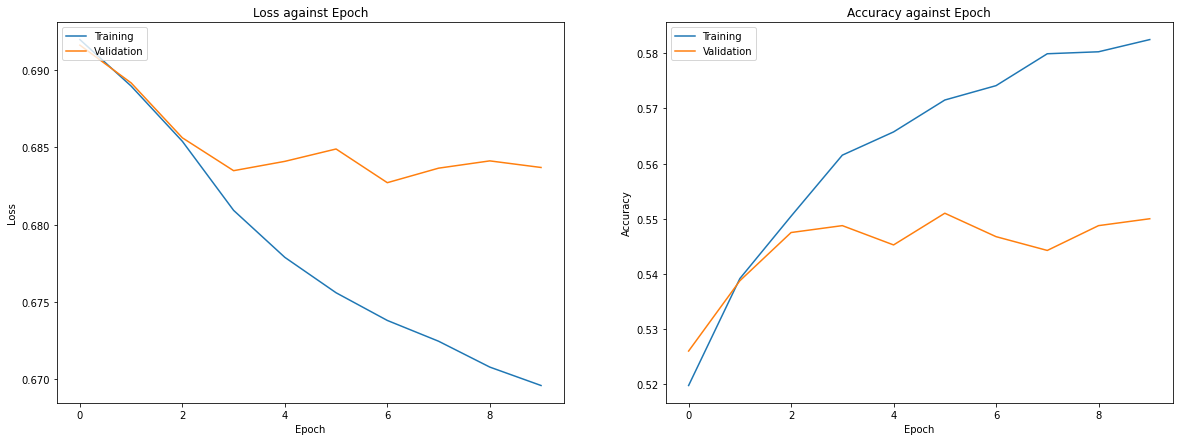

In [ ]:
# Plot the training history of the model
if TRAIN:
    plot_history(hist_lstm)

In [ ]:
# Download and load the best LSTM model
if TRAIN == False:
    !gdown --id 1HBvU5p3y7HXJcHkDWyivCsKHpGfpHg0x
    best_lstm_model = load_model('/content/best_lstm_model.h5')

Downloading...
From: https://drive.google.com/uc?id=1HBvU5p3y7HXJcHkDWyivCsKHpGfpHg0x
To: /content/best_lstm_model.h5
100% 5.32M/5.32M [00:00<00:00, 32.7MB/s]


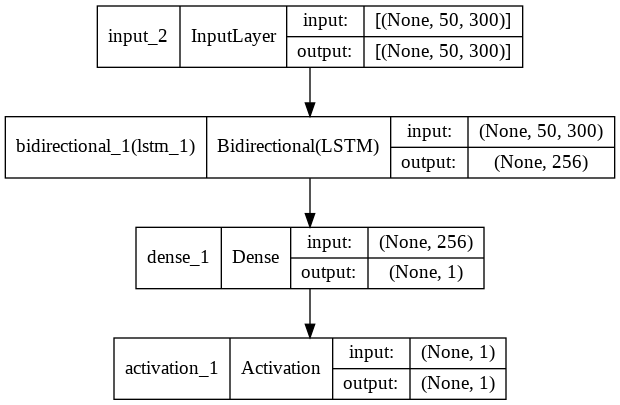

In [ ]:
# Plot the model's architecture
plot_model(best_lstm_model, show_shapes=True, show_layer_names=True)

              precision    recall  f1-score   support

           0       0.60      0.79      0.68       100
           1       0.70      0.48      0.57       100

    accuracy                           0.64       200
   macro avg       0.65      0.64      0.63       200
weighted avg       0.65      0.64      0.63       200



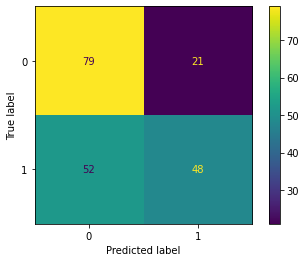

In [ ]:
# Evaluate the best LSTM model on the test set
true, pred = majority_voting(best_lstm_model)
print(classification_report(true, pred))
plot_cm(true, pred)

### Bidirectional GRU

In [ ]:
# Bidirectional GRU with a Dense layer
if TRAIN:
    def gru_model(hp):
        model = Sequential()
        model.add(InputLayer(input_shape=(50, 300)))
        model.add(Bidirectional(GRU(units=hp.Int('units', min_value=64, max_value=320, step=64, default=256))))
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-5), metrics='Accuracy')
        return model

    # Hyperparameter optimization using random search
    tuner = RandomSearch(gru_model, objective=Objective('val_Accuracy', direction='max'), max_trials=3, overwrite=True)
    tuner.search(train_features, train_labels, epochs=5, validation_data=(val_features, val_labels), batch_size=32)

Trial 3 Complete [00h 00m 44s]
val_Accuracy: 0.5325000286102295

Best val_Accuracy So Far: 0.5515000224113464
Total elapsed time: 00h 03m 00s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Train the best model for 10 epochs
if TRAIN:
    best_gru_model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
    hist_gru = best_gru_model.fit(train_features, train_labels, epochs=10, validation_data=(val_features, val_labels), batch_size=32, 
                                  callbacks=EarlyStopping(monitor='val_loss', patience=3))

    # Save the best model
    best_gru_model.save('best_gru_model.h5')

Epoch 1/10
875/875 [==============================] - 12s 11ms/step - loss: 0.6940 - Accuracy: 0.5141 - val_loss: 0.6904 - val_Accuracy: 0.5383
Epoch 2/10
875/875 [==============================] - 9s 10ms/step - loss: 0.6901 - Accuracy: 0.5310 - val_loss: 0.6887 - val_Accuracy: 0.5435
Epoch 3/10
875/875 [==============================] - 9s 10ms/step - loss: 0.6872 - Accuracy: 0.5431 - val_loss: 0.6894 - val_Accuracy: 0.5337
Epoch 4/10
875/875 [==============================] - 9s 10ms/step - loss: 0.6852 - Accuracy: 0.5462 - val_loss: 0.6890 - val_Accuracy: 0.5310
Epoch 5/10
875/875 [==============================] - 9s 10ms/step - loss: 0.6829 - Accuracy: 0.5562 - val_loss: 0.6849 - val_Accuracy: 0.5487
Epoch 6/10
875/875 [==============================] - 9s 10ms/step - loss: 0.6809 - Accuracy: 0.5600 - val_loss: 0.6846 - val_Accuracy: 0.5477
Epoch 7/10
875/875 [==============================] - 9s 10ms/step - loss: 0.6789 - Accuracy: 0.5642 - val_loss: 0.6837 - val_Accuracy: 0.551

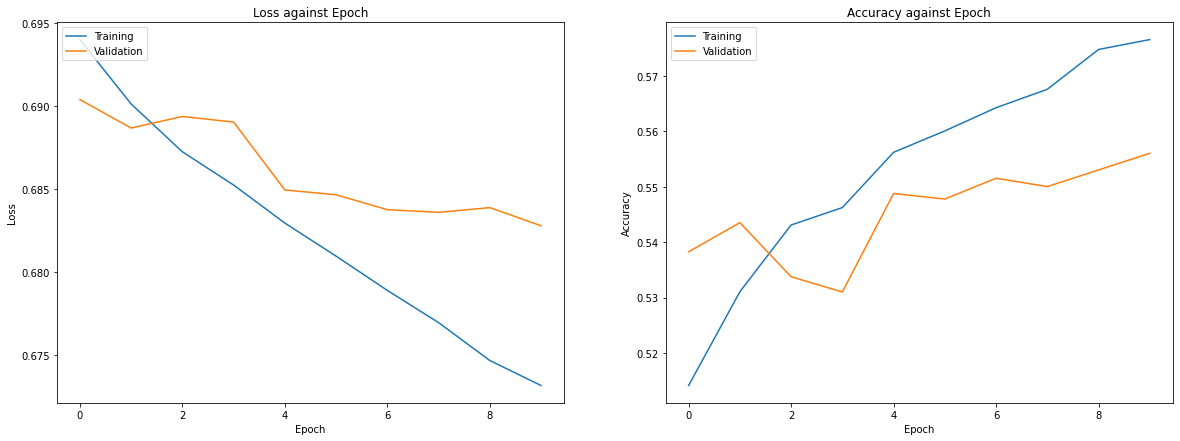

In [ ]:
# Plot the training history of the model
if TRAIN:
    plot_history(hist_gru)

In [ ]:
# Download and load the best GRU model
if TRAIN == False:
    !gdown --id 1vFEaypgQJ_kaI1e_NrMrQUzdIsPvo3Qq
    best_gru_model = load_model('/content/best_gru_model.h5')

Downloading...
From: https://drive.google.com/uc?id=1vFEaypgQJ_kaI1e_NrMrQUzdIsPvo3Qq
To: /content/best_gru_model.h5
100% 10.3M/10.3M [00:00<00:00, 47.9MB/s]


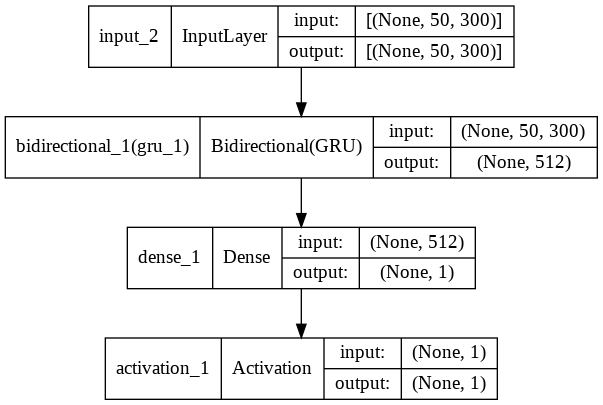

In [ ]:
# Plot the model's architecture
plot_model(best_gru_model, show_shapes=True, show_layer_names=True)

              precision    recall  f1-score   support

           0       0.69      0.59      0.64       100
           1       0.64      0.74      0.69       100

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.66       200
weighted avg       0.67      0.67      0.66       200



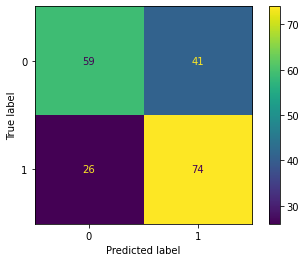

In [ ]:
# Evaluate the best GRU model on the test set
true, pred = majority_voting(best_gru_model)
print(classification_report(true, pred))
plot_cm(true, pred)

## Model (Transformer)

In [ ]:
# Utilised functions
class Dataset(torch.utils.data.Dataset):    
    def __init__(self, inputs, labels):          
        self.inputs = inputs['input_ids']
        self.attentions = inputs['attention_mask']      
        self.labels = labels

    def __len__(self):
        return len(self.inputs)
     
    def __getitem__(self, idx):
        input = self.inputs[idx]
        attention = self.attentions[idx]

        if self.labels is None:
            sample = {'input_ids': input, 'attention_mask': attention}
        
        else:
            label = self.labels[idx]
            sample = {'input_ids': input, 'attention_mask': attention, 'labels': label}
        
        return sample

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    return {'accuracy': accuracy}

In [ ]:
# Check if the GPU is available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Import the transformer model
tokenizer = AutoTokenizer.from_pretrained('finiteautomata/bertweet-base-sentiment-analysis')

if TRAIN:
    model = AutoModelForSequenceClassification.from_pretrained('finiteautomata/bertweet-base-sentiment-analysis', num_labels=2, ignore_mismatched_sizes=True).to(device)

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
# Encode the texts using a pretrained tokenizer
train_features = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
val_features = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')
test_features = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='pt')

# Change data type of labels to int64
train_labels = y_train.astype('int64')
val_labels = y_val.astype('int64')
test_labels = y_test.astype('int64')

# Create the training, validation and test datasets
train_dataset = Dataset(train_features, list(train_labels))
val_dataset = Dataset(val_features, list(val_labels))
test_dataset = Dataset(test_features, None)

In [ ]:
# Define the trainer
if TRAIN:
    args = TrainingArguments(
        output_dir='output',
        evaluation_strategy ='steps',
        eval_steps=100,
        save_total_limit=1,
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        num_train_epochs=10,
        metric_for_best_model='accuracy',
        load_best_model_at_end=True)

    best_transformer_model = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,   
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])
  
    # Train the pre-trained model
    best_transformer_model.train()

***** Running training *****
  Num examples = 28000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 8750


Step,Training Loss,Validation Loss,Accuracy
100,No log,0.676410,0.586750
200,No log,0.665507,0.598500
300,No log,0.658822,0.602750
400,No log,0.676477,0.598500
500,0.671600,0.652739,0.603000
600,0.671600,0.647714,0.620000
700,0.671600,0.640768,0.625500
800,0.671600,0.651163,0.605750
900,0.671600,0.640692,0.618500
1000,0.641600,0.664567,0.625250


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
Saving model checkpoint to output/checkpoint-1000
Configuration saved in output/checkpoint-1000/config.json
Model weights saved in 

TrainOutput(global_step=2700, training_loss=0.5804003849735967, metrics={'train_runtime': 2264.1663, 'train_samples_per_second': 123.666, 'train_steps_per_second': 3.865, 'total_flos': 5461198842816000.0, 'train_loss': 0.5804003849735967, 'epoch': 3.09})

In [ ]:
# Save the transfomer weights folder as a zip file
if TRAIN:
    shutil.make_archive('best_transformer_model', 'zip', '/content/output')

'/content/best_transformer_model.zip'

In [ ]:
# Download and load the best transformer model
if TRAIN == False:
    !gdown --id 1e8zqNcnfTao77Dt2NgPT4JNsb6GVwrun
    !unzip -q -o best_transformer_model.zip -d /content
    best_transformer_model = Trainer(AutoModelForSequenceClassification.from_pretrained('/content/best_transformer_model').to(device))

Downloading...
From: https://drive.google.com/uc?id=1e8zqNcnfTao77Dt2NgPT4JNsb6GVwrun
To: /content/best_transformer_model.zip
100% 1.26G/1.26G [00:17<00:00, 72.1MB/s]


***** Running Prediction *****
  Num examples = 8000
  Batch size = 8


              precision    recall  f1-score   support

           0       0.85      0.67      0.75       100
           1       0.73      0.88      0.80       100

    accuracy                           0.78       200
   macro avg       0.79      0.78      0.77       200
weighted avg       0.79      0.78      0.77       200



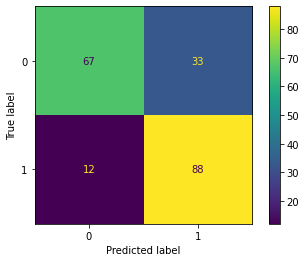

In [ ]:
# Evaluate the best transformer model on the test set
true, pred = majority_voting(best_transformer_model, transformer=True)
print(classification_report(true, pred))
plot_cm(true, pred)